In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
raw_data = pd.read_csv("jamb_exam_results.csv")
raw_data.columns = raw_data.columns.str.lower().str.replace(' ', '_')
raw_data.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [3]:
len(raw_data), raw_data.isnull().sum()

(5000,
 jamb_score                        0
 study_hours_per_week              0
 attendance_rate                   0
 teacher_quality                   0
 distance_to_school                0
 school_type                       0
 school_location                   0
 extra_tutorials                   0
 access_to_learning_materials      0
 parent_involvement                0
 it_knowledge                      0
 student_id                        0
 age                               0
 gender                            0
 socioeconomic_status              0
 parent_education_level          891
 assignments_completed             0
 dtype: int64)

In [4]:
# Remove the student_id column.
# Fill missing values with zeros.
columns = list(set(raw_data.columns) - set(["student_id"]))
sample_data = raw_data.loc[:, columns]
sample_data.fillna(value="UnKnown", inplace=True)
sample_data.head()

,jamb_score,school_location,age,it_knowledge,gender,school_type,attendance_rate,parent_education_level,extra_tutorials,socioeconomic_status,teacher_quality,distance_to_school,access_to_learning_materials,study_hours_per_week,parent_involvement,assignments_completed
0,192,Urban,17,Medium,Male,Public,78,Tertiary,Yes,Low,4,12.4,Yes,22,High,2
1,207,Rural,15,High,Male,Public,88,UnKnown,No,High,4,2.7,Yes,14,High,1
2,182,Rural,20,Medium,Female,Public,87,Tertiary,Yes,High,2,9.6,Yes,29,High,2
3,210,Urban,22,High,Female,Public,99,Tertiary,No,Medium,2,2.6,Yes,29,Medium,1
4,199,Urban,22,Medium,Female,Public,98,Tertiary,No,Medium,3,8.8,Yes,12,Medium,1


In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, median_absolute_error, max_error, root_mean_squared_error

feature_columns = list(set(sample_data.columns) - set(["jamb_score"]))
X = sample_data.loc[:, feature_columns]
y = sample_data["jamb_score"]

# Do train/validation/test split with 60%/20%/20% distribution.
# Use the train_test_split function and set the random_state parameter to 1.
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

X_full_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_full_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
dict_transformer = DictVectorizer(sparse=True)
dict_transformer.fit(X_train.to_dict(orient="records"))

x_train = dict_transformer.transform(X_train.to_dict(orient="records"))
x_val = dict_transformer.transform(X_val.to_dict(orient="records"))
x_test = dict_transformer.transform(X_test.to_dict(orient="records"))

[Text(0.5, 0.75, 'study_hours_per_week <= 18.5\nsquared_error = 2216.323\nsamples = 3000\nvalue = 172.752'),
 Text(0.25, 0.25, 'squared_error = 1599.446\nsamples = 1425\nvalue = 155.244'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'squared_error = 2246.182\nsamples = 1575\nvalue = 188.593'),
 Text(0.625, 0.5, '  False')]

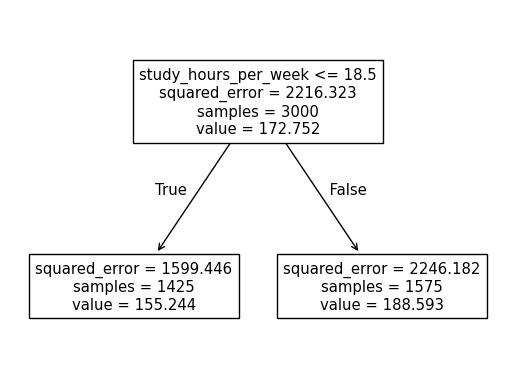

In [6]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(max_depth=1)
regressor.fit(x_train, y_train)
tree.plot_tree(regressor, feature_names=dict_transformer.get_feature_names_out())

In [1]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
regressor.fit(x_train, y_train)


ModuleNotFoundError: No module named 'sklearn'

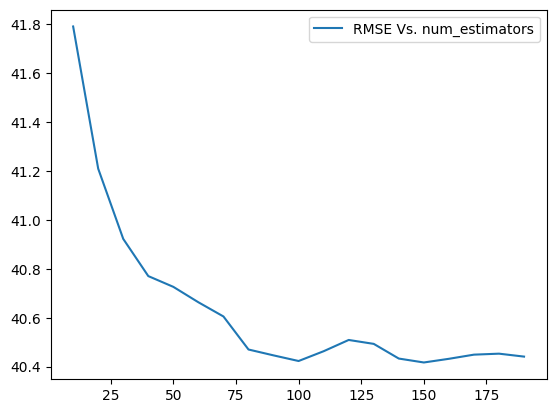

In [8]:
num_estimators = np.arange(10, 200, 10)
rmse_history = []

for n_estimators in num_estimators:
    regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    regressor.fit(x_train, y_train)
    rmse_history.append(np.round(root_mean_squared_error(y_val, regressor.predict(x_val)), decimals=3))
    
plt.plot(num_estimators, np.array(rmse_history), label="RMSE Vs. num_estimators")
plt.legend()

##### Question 4

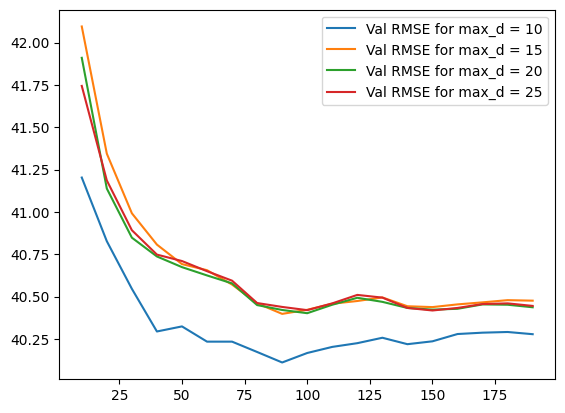

In [10]:
tree_depths = np.array([10, 15, 20, 25])
num_estimators = np.arange(10, 200, 10)
rmse_history = []

for max_depth in tree_depths:
    exp_history = []
    for n_estimators in num_estimators:
        regressor = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=1, n_jobs=-1)
        regressor.fit(x_train, y_train)
        exp_history.append(np.round(root_mean_squared_error(y_val, regressor.predict(x_val)), decimals=3))
    rmse_history.append(exp_history)
    
    plt.plot(num_estimators, np.array(exp_history), label=f"Val RMSE for max_d = {max_depth}")
plt.legend()
plt.show()

In [11]:
agg_rmse_history = np.array(rmse_history).sum(axis=1)

print(f"The best max_depth (using the mean RMSE) is {tree_depths[np.argmin(agg_rmse_history)]}")

The best max_depth (using the mean RMSE) is 10


##### Question 5

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

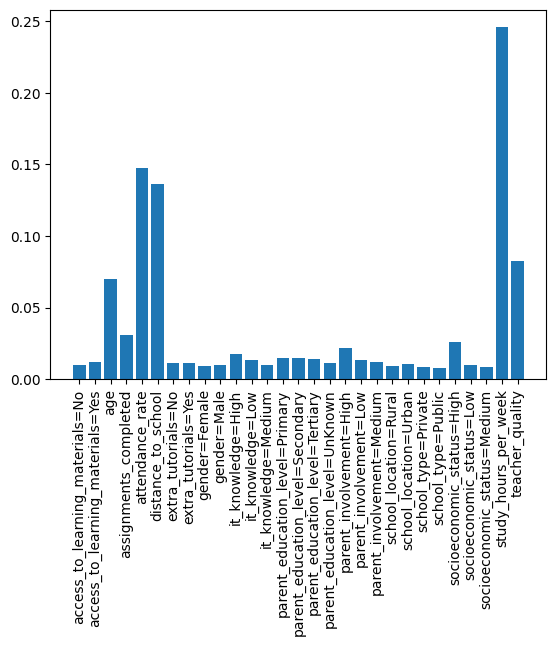

In [12]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
regressor.fit(x_train, y_train)
feature_importances = list(zip(dict_transformer.get_feature_names_out(), regressor.feature_importances_))
plt.bar(dict_transformer.get_feature_names_out(), regressor.feature_importances_)
plt.xticks(rotation=90)

In [13]:
print(f"The most important feature is {dict_transformer.get_feature_names_out()[np.argmax(regressor.feature_importances_)]}")

The most important feature is study_hours_per_week


##### Question 6

In [14]:
import xgboost as xgb
from xgboost import DMatrix


xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1}

train_dataset = DMatrix(data=x_train, label=y_train, feature_names=list(dict_transformer.get_feature_names_out()))
val_dataset = DMatrix(data=x_val, label=y_val, feature_names=list(dict_transformer.get_feature_names_out()))
test_dataset = DMatrix(data=x_test, label=y_test, feature_names=list(dict_transformer.get_feature_names_out()))


watchlist = [(train_dataset, 'train'), (val_dataset, 'validation')]

booster = xgb.train(xgb_params, train_dataset, evals=watchlist, num_boost_round=10)

[0]	train-rmse:42.69384	validation-rmse:44.89114
[1]	train-rmse:39.83326	validation-rmse:43.07010
[2]	train-rmse:37.94542	validation-rmse:42.00332
[3]	train-rmse:36.56125	validation-rmse:41.46452
[4]	train-rmse:35.44252	validation-rmse:40.88896
[5]	train-rmse:34.57756	validation-rmse:40.69096
[6]	train-rmse:33.84230	validation-rmse:40.59315
[7]	train-rmse:33.25929	validation-rmse:40.47993
[8]	train-rmse:32.79415	validation-rmse:40.45326
[9]	train-rmse:32.16019	validation-rmse:40.43929


In [15]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1}

train_dataset = DMatrix(data=x_train, label=y_train, feature_names=list(dict_transformer.get_feature_names_out()))
val_dataset = DMatrix(data=x_val, label=y_val, feature_names=list(dict_transformer.get_feature_names_out()))
test_dataset = DMatrix(data=x_test, label=y_test, feature_names=list(dict_transformer.get_feature_names_out()))


watchlist = [(train_dataset, 'train'), (val_dataset, 'validation')]

booster = xgb.train(xgb_params, train_dataset, evals=watchlist, num_boost_round=10)

[0]	train-rmse:45.49999	validation-rmse:47.00533
[1]	train-rmse:44.12948	validation-rmse:45.92344
[2]	train-rmse:42.94858	validation-rmse:44.98366
[3]	train-rmse:41.90896	validation-rmse:44.25755
[4]	train-rmse:40.96728	validation-rmse:43.57339
[5]	train-rmse:40.17514	validation-rmse:43.11181
[6]	train-rmse:39.40436	validation-rmse:42.61054
[7]	train-rmse:38.71199	validation-rmse:42.18883
[8]	train-rmse:38.08081	validation-rmse:41.86754
[9]	train-rmse:37.57559	validation-rmse:41.64338


In [16]:
# # # eta = 0.1 leads to better performance

#### End of Task! Looking forward to solving the next assignment